In [2]:
from basic_tools import *
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [3]:
h2_total=pd.read_csv(h2_total_par_filtered_path,index_col='phenotype')
h2_total.shape

(497, 7602)

# Parsing result of partitioned LDSC

In [4]:
suffix_bp_list_power="bp300 bp128 bp64 bp32 bp16 bp8".split()

In [5]:
regression_result_bp_list_dict=dict([make_regression_result_list(h2_total,phenotype,suffix_bp_list_power) for phenotype in phenotypes_par_filtered.index])

In [6]:
def calculate_per_bp_var(regression_result_list_dict,suffix_list,mode='default'):
    var_list=[]
    for idx,value in enumerate(suffix_list):
        h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/regression_result_list[idx]['category'].apply(category_to_format,args=('bp_range',))).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        #h2_df=pd.DataFrame([[phenotype]+((regression_result_list[idx]['h2']/regression_result_list[idx]['h2'].sum())/1).tolist() for phenotype,regression_result_list in regression_result_list_dict.items()])
        h2_df=h2_df.set_index(0)

        if mode=='default':
            values=h2_df.var(axis=1)
        elif mode=='mono':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            values=h2_df.var(axis=1)/h2_mono.var()
        elif mode=='max_and_poly':
            h2_mono=pd.Series(0.0,index=np.arange(h2_df.shape[1]));h2_mono[0]=1/category_to_format(list(regression_result_bp_list_dict.values())[0][idx]['category'].loc[0],'bp_range',)
            h2_poly=pd.Series(1.0,index=np.arange(h2_df.shape[1]));h2_poly=h2_poly/list(regression_result_bp_list_dict.values())[0][idx]['category'].apply(category_to_format,args=('bp_range',)).sum()
            #var_list.append(1-(h2_df.var(axis=1)-h2_poly.var())/(h2_df.var(axis=1).max()-h2_poly.var()))#-h2_df.mean(axis=1))
            values=(h2_df.var(axis=1)-0)/(h2_df.var(axis=1).max()-0)
        elif mode=='test':
            values=-np.log10(h2_df.var(axis=1))
            8.580318	
            values=(values.max()-values)
            values=1-values/values.max()
            #values=values-values.min()
            #values=1-(values-values.min())/(values.max()-values.min())
        else:
            raise
        var_list.append(values)
    var_df=pd.DataFrame(var_list,index=suffix_list)
    return var_df.T
per_bp_var=calculate_per_bp_var(regression_result_bp_list_dict,suffix_bp_list_power,mode='test')
#per_bp_var.sort_values('bp8',ascending=False)

found that variables 'gwas_result_sample','chr_bp_max' were not loaded. trying to load the variables
gwas_result_sample.shape: (13294674, 19)


In [7]:
def anova_regression_result_times(regression_result,times):
    h2_upscale=pd.DataFrame([(regression_result['h2']/regression_result['h2'].sum())/regression_result['category'].apply(category_to_format,args=('bp_range',)).values,regression_result['category'].apply(category_to_format,args=(times,))]).T    
    h2_upscale_grouped=(h2_upscale.groupby('category')['h2'].apply(list))
    f_statistic,f_statistic_pval=st.f_oneway(*h2_upscale_grouped.values)    
    #print(h2_upscale_grouped)
    return f_statistic,f_statistic_pval

In [8]:
regression_result_bp_list_dict['23115_irnt'][5].shape

(357, 7)

In [9]:
anova_list_list_times=[[phenotype]+list(map(lambda x: anova_regression_result_times(regression_result_list[-1],x),list(range(len(suffix_bp_list_power)-1,0,-1)))) for phenotype,regression_result_list in regression_result_bp_list_dict.items()]

In [10]:
anova_df_f_times=pd.DataFrame([[anova_list[0]]+[anova[0] for anova in anova_list[1:]] for idx,anova_list in enumerate(anova_list_list_times)])
anova_df_f_times=anova_df_f_times.set_index(0)
anova_df_f_times.columns=suffix_bp_list_power[:-1]
anova_df_f_times.head()

anova_df_pval_times=pd.DataFrame([[anova_list[0]]+[anova[1] for anova in anova_list[1:]] for idx,anova_list in enumerate(anova_list_list_times)])
anova_df_pval_times=anova_df_pval_times.set_index(0)
anova_df_pval_times.columns=suffix_bp_list_power[:-1]
anova_df_pval_times.head()

,bp300,bp128,bp64,bp32,bp16
0,,,,,
50_irnt,0.009956,0.002237,0.000001,0.000005,1.779190e-03
20153_irnt,0.011421,0.006412,0.000064,0.000062,9.269654e-04
5097_irnt,0.000011,0.000772,0.049351,0.000163,3.596908e-37
5098_irnt,0.000028,0.001413,0.055799,0.000081,1.921421e-35
5099_irnt,0.000052,0.002361,0.057114,0.000182,5.251360e-33


In [11]:
plt.rcParams['font.family']='Arial'

In [12]:
plt.rcParams["figure.figsize"] = (80,5)
plt.rcParams["font.size"] = 30


anova_plot_data=anova_df_pval_times.copy()
anova_plot_data.columns=anova_plot_data.columns.str.replace('bp','')+'Mb'
anova_plot_data.columns=anova_plot_data.columns.str.replace('300Mb','Chr')
#anova_plot_data=-np.log10(anova_plot_data.loc[per_bp_var['bp8'].sort_values(ascending=False).index].iloc[:50,:].T)#,cmap=plt.cm.rainbow)
#
anova_plot_data=-np.log10(anova_plot_data.loc[per_bp_var['bp8'].sort_values(ascending=False).index].T)#,cmap=plt.cm.rainbow)

#.loc[index_select]



In [13]:
"""
description_dict_merge_path=base_path+'description_dict_merge.tsv'

description_dict_merge=pd.read_csv(description_dict_merge_path,sep='\t',index_col='description')

description_dict_merge['description_pub_anova']=description_dict_merge['description_pub_basic']
description_dict_merge['description_abbr_anova']=description_dict_merge['description_abbr_basic']
                                                                       
description_dict_merge.to_csv(base_path+"description_dict_merge.tsv",sep='\t')

"""

'\ndescription_dict_merge_path=base_path+\'description_dict_merge.tsv\'\n\ndescription_dict_merge=pd.read_csv(description_dict_merge_path,sep=\'\t\',index_col=\'description\')\n\ndescription_dict_merge[\'description_pub_anova\']=description_dict_merge[\'description_pub_basic\']\ndescription_dict_merge[\'description_abbr_anova\']=description_dict_merge[\'description_abbr_basic\']\n                                                                       \ndescription_dict_merge.to_csv(base_path+"description_dict_merge.tsv",sep=\'\t\')\n\n'

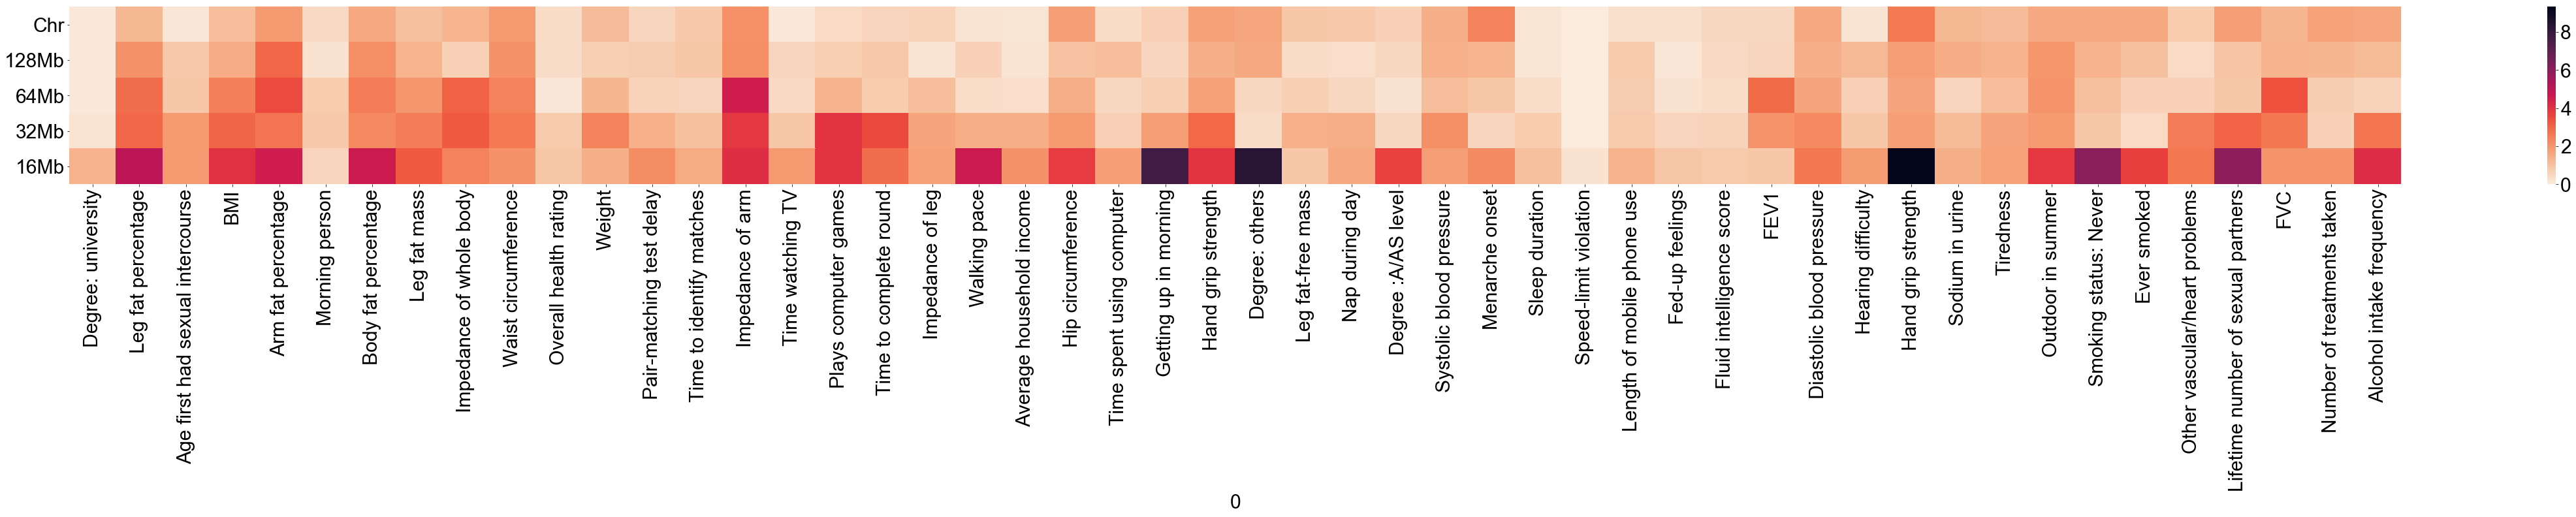

In [14]:
plot_data=anova_plot_data.iloc[:,:50]
plot_data.columns=plot_data.columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori'))
sns.heatmap(plot_data,cmap=sns.cm.rocket_r)

In [15]:
len_group=5
index_select=[value for idx,value in enumerate(anova_plot_data.columns) if idx%50<len_group]

In [16]:
#description_to_short("3mm strong meridian (right)","pub",suffix="anova")

In [17]:
description_dict_merge=pd.read_csv(description_dict_merge_path,sep='\t',index_col='description')

def description_to_short(desc,mode='pub',suffix="basic"):

    description_dict=description_dict_merge
    
    if not mode in ['ori','pub','abbr','abbr_pub','abbr_pub_ori']:
        raise    
    if desc in description_dict.index:
        if mode=='ori':
            return desc
        elif mode=='pub':
            #print(correlation_description_dict['description_pub'].loc['Tobacco smoking: Ex-smoker'],description_dict['description_pub'].loc['Tobacco smoking: Ex-smoker'])
            return description_dict['description_pub'+"_"+suffix].loc[desc]
        elif mode=='abbr':
            return description_dict['description_abbr'+"_"+suffix].loc[desc]
        elif mode=='abbr_pub':
            abbr=description_to_short(desc,mode='abbr',suffix=suffix)
            return description_to_short(desc,mode='pub',suffix=suffix) if type(abbr)==float or abbr=='' else abbr
        elif mode=='abbr_pub_ori':
            abbr_pub=description_to_short(desc,mode='abbr_pub',suffix=suffix)
            #print(abbr_pub)
            return desc if type(abbr_pub)==float or abbr_pub=='' else abbr_pub
    else:
        return np.nan


In [18]:
anova_plot_data[index_select].columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori',"anova"))

Index(['Degree: university', 'Leg fat percentage',
       'Age first had sexual intercourse', 'BMI', 'Arm fat percentage',
       'Creatinine (enzymatic) in urine', 'Risk taking', 'Neuroticism score',
       'Long-standing illness, disability or infirmity', 'Mood swings',
       'Diseases of the digestive system', 'Accommodation own or rent', 'FEV1',
       'Pulse rate, automated reading', 'Smoking status: Previous',
       'No medication for cholesterol, hormones etc.',
       'Relative age voice broke', 'Average weekly red wine intake',
       'Blood pressure medication(3)', 'Reticulocyte percentage',
       'Eosinophill count', 'Tinnitus: No, never',
       'Blood pressure medication(4)', 'Financial situation satisfaction',
       'Eosinophill percentage', 'Ramipril', 'Hypothyroidism/myxoedema',
       'Tobacco smoking: Ex-smoker',
       'Light smokers, at least 100 smokes in lifetime',
       'Major coronary heart disease event',
       'Illnesses of siblings: Severe depression',


0
1
2
3
4
5
6
7
8
9


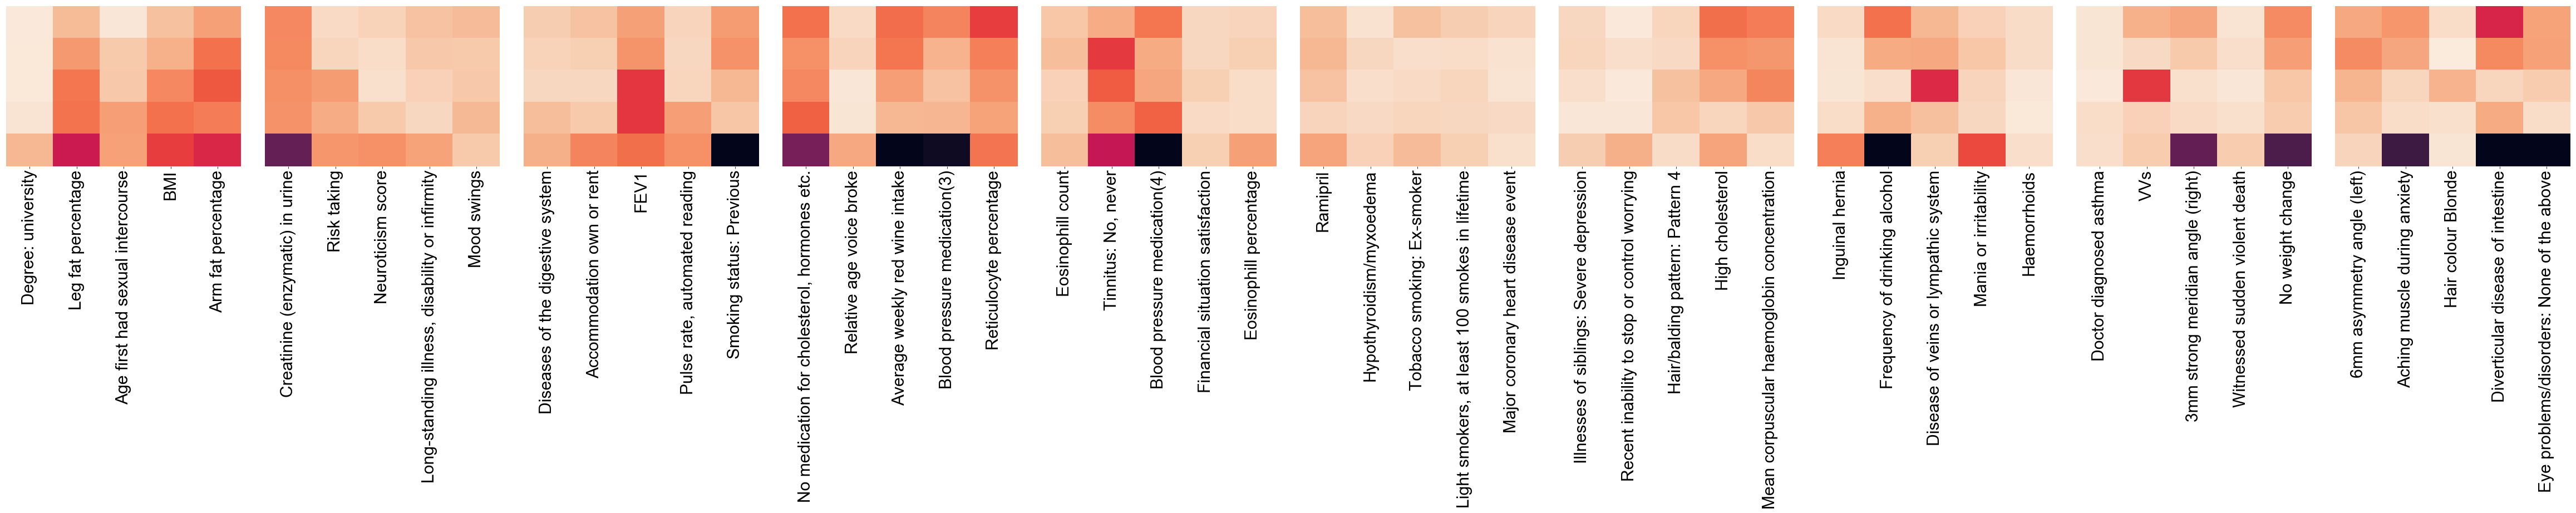

In [21]:
plt.rcParams["figure.figsize"] = (80,5)
plt.rcParams["font.size"] = 30

fig, axes =plt.subplots(ncols=len(index_select)//len_group)

left = 0.07; right=0.87
bottom = 0.1; top = 0.9
#fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(figw, figh), gridspec_kw=gridspec_kw)
asp=0.5

plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=0.1, hspace=0.1*asp )

for i in range(0,len(index_select)//len_group):
    print(i)
    plot_data=anova_plot_data[index_select[i*len_group:(i+1)*len_group]]
    plot_data.columns=plot_data.columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori',"anova"))
    
    sns.heatmap(plot_data, ax=axes[i], yticklabels=False,cbar=False,cmap=sns.cm.rocket_r,vmin=0,vmax=10)
    #axes[i].set_ylabel('')    
    axes[i].set_xlabel('')

0
1
2
3
4
5
6
7
8
9


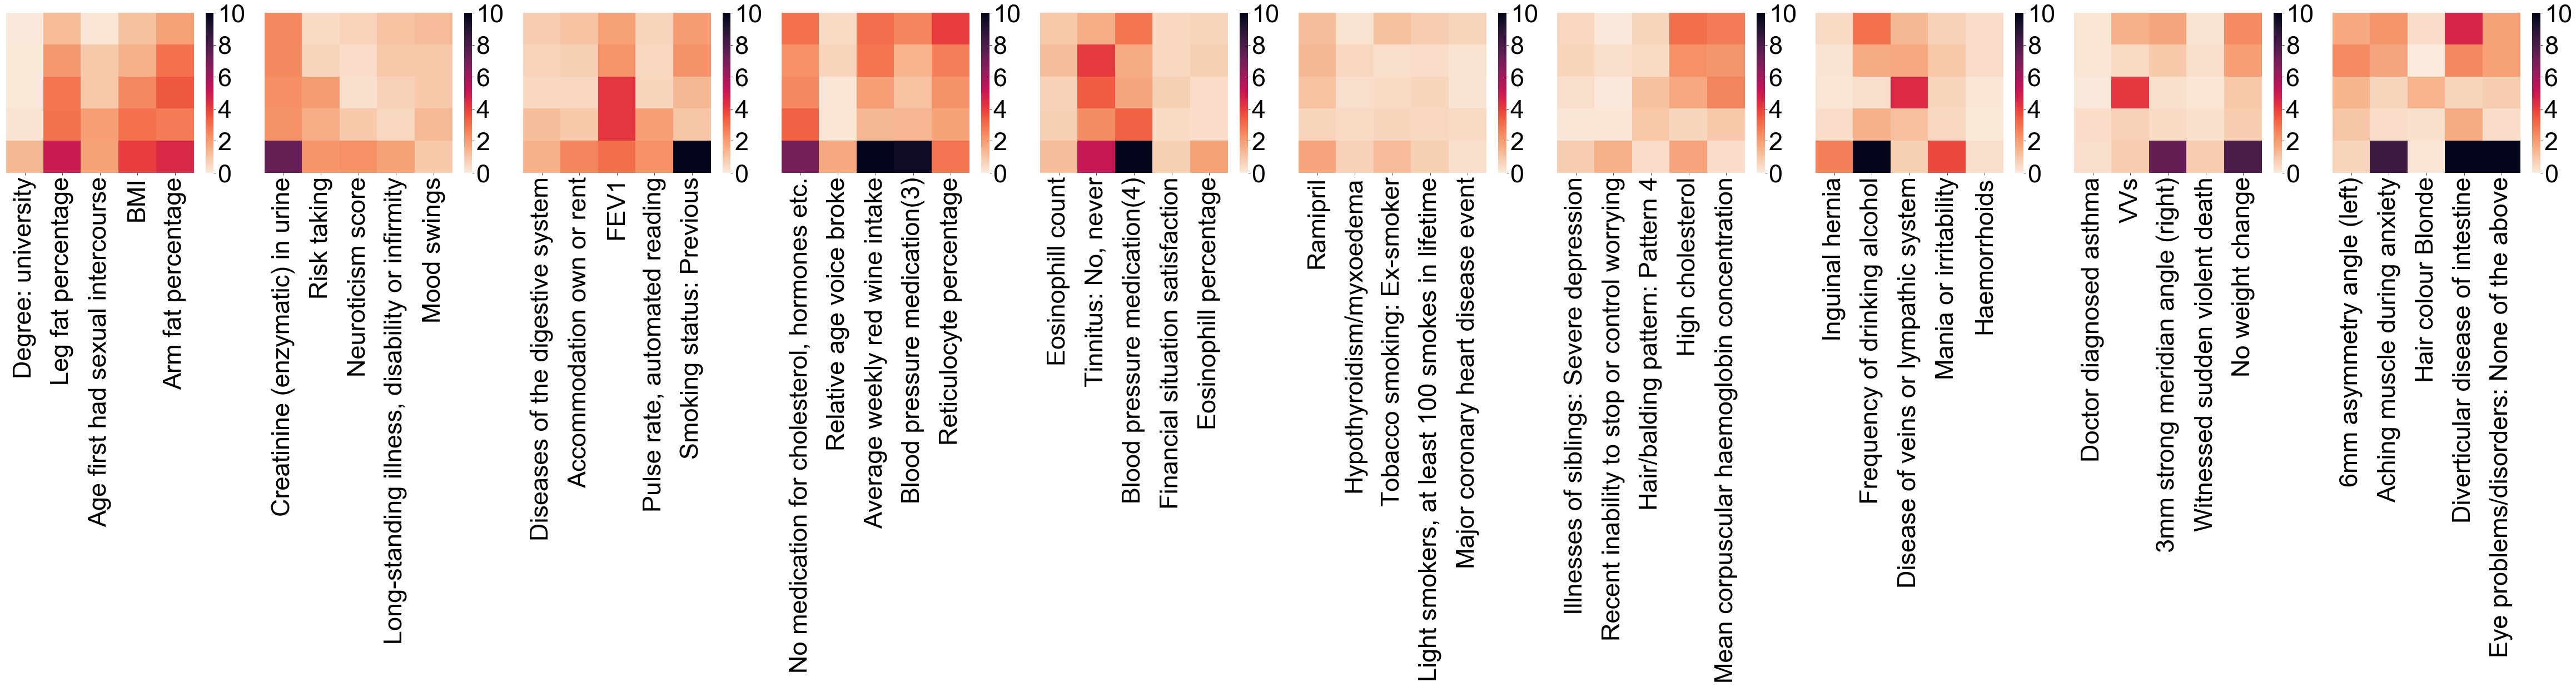

In [53]:
plt.rcParams["figure.figsize"] = (80,5)
plt.rcParams["font.size"] = 45

fig, axes =plt.subplots(ncols=len(index_select)//len_group)

left = 0.07; right=0.87
bottom = 0.1; top = 0.9
#fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(figw, figh), gridspec_kw=gridspec_kw)
asp=0.5

plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=0.1, hspace=0.1*asp )

for i in range(0,len(index_select)//len_group):
    print(i)
    plot_data=anova_plot_data[index_select[i*len_group:(i+1)*len_group]]
    plot_data.columns=plot_data.columns.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub_ori',"anova"))
    
    sns.heatmap(plot_data, ax=axes[i], yticklabels=False,cbar=False,cmap=sns.cm.rocket_r,vmin=0,vmax=10)
    #axes[i].set_ylabel('')    
    axes[i].set_xlabel('')
plt.savefig('savefig_anova1.png',bbox_inches="tight")

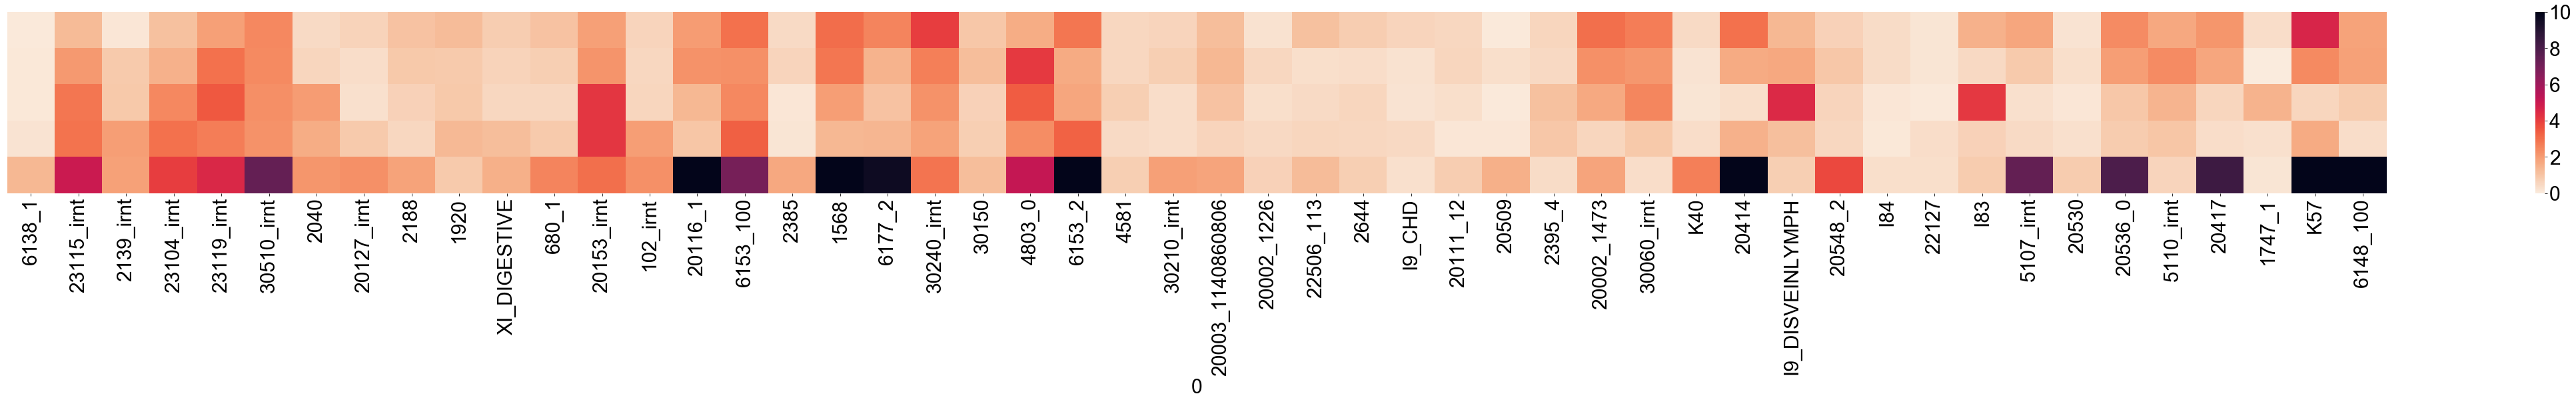

In [20]:
sns.heatmap(anova_plot_data[index_select], yticklabels=False,cbar=True,cmap=sns.cm.rocket_r,vmin=0,vmax=10)
#plt.xticks([])

In [428]:
#pca_result.loc[index_select]

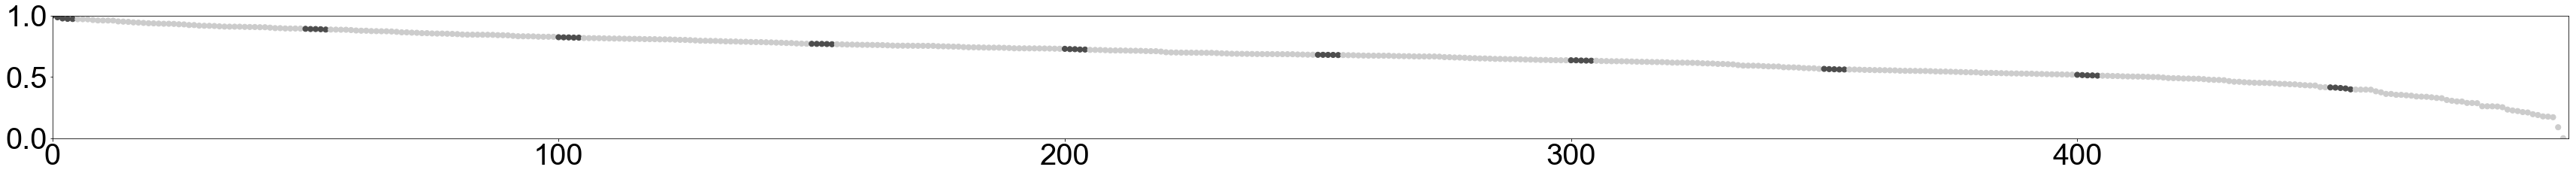

In [50]:
plt.rcParams["figure.figsize"] = (60,3)
plt.rcParams["font.size"] = 40

plt.scatter(list(range(0,len(per_bp_var['bp8'][anova_plot_data.columns]))),per_bp_var['bp8'][anova_plot_data.columns],color=[(0.3,0.3,0.3,1) if col in index_select else (0.8,0.8,0.8,1) for col in anova_plot_data.columns],s=50)

plt.xlim(0,len(anova_plot_data.columns))
plt.ylim(0,1)

plt.savefig('savefig_polygenicity.png',bbox_inches="tight")

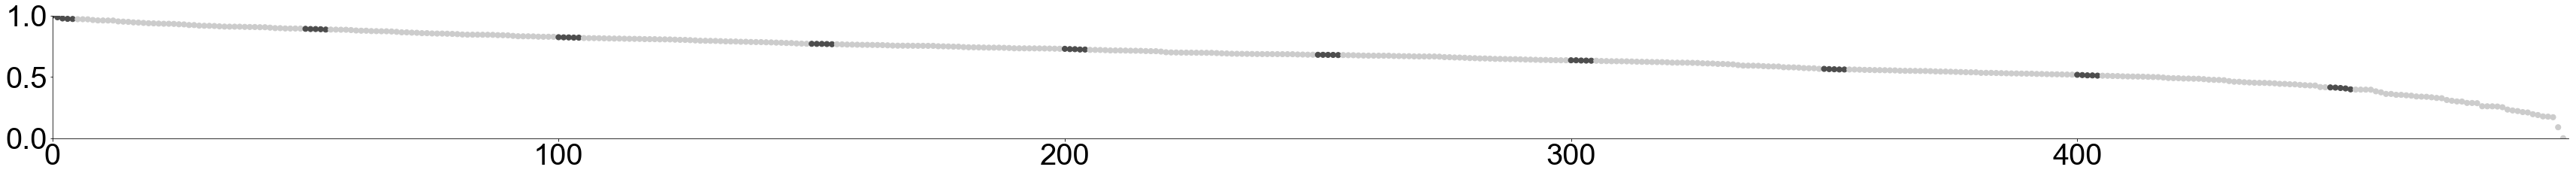

In [52]:
plt.rcParams["figure.figsize"] = (60,3)
plt.rcParams["font.size"] = 40

plt.scatter(list(range(0,len(per_bp_var['bp8'][anova_plot_data.columns]))),per_bp_var['bp8'][anova_plot_data.columns],color=[(0.3,0.3,0.3,1) if col in index_select else (0.8,0.8,0.8,1) for col in anova_plot_data.columns],s=50)

plt.xlim(0,len(anova_plot_data.columns))
plt.ylim(0,1)
sns.despine()
plt.savefig('savefig_polygenicity.png',bbox_inches="tight")

In [469]:
tsne_result.merge(anova_plot_data.T,left_index=True,right_index=True).loc[index_select]

,0,1,Chr,128Mb,64Mb,32Mb,16Mb
0,,,,,,,
6138_1,-30.174879,-2.003766,0.077730,0.105640,0.082091,0.227632,1.361490
23115_irnt,30.262423,-0.644532,1.262154,2.104953,2.868289,2.963532,5.021501
2139_irnt,-13.305619,7.902073,0.152632,0.875355,0.916412,1.960877,1.911175
23104_irnt,28.438972,-0.703526,1.122422,1.509764,2.496869,3.002751,4.025293
23119_irnt,36.368664,8.089181,1.933260,2.989561,3.504301,2.725754,4.563324
30510_irnt,34.230556,-21.253618,2.492364,2.452944,2.313926,2.241048,7.408632
2040,10.441192,12.707636,0.450463,0.567395,2.010463,1.632456,2.155906
20127_irnt,-13.623932,-4.225992,0.655401,0.368730,0.305676,0.891032,2.303790
2188,-6.570095,21.526310,1.072467,0.909967,0.697245,0.520035,1.843263


In [ ]:
anova_plot_data.T.head()

In [429]:
#anova_plot_data_normalized=(anova_plot_data-anova_plot_data.mean())/anova_plot_data.std()
#anova_plot_data_normalized=(anova_plot_data-anova_plot_data.min())/(anova_plot_data.max()-anova_plot_data.min())
#anova_plot_data_normalized=
anova_plot_data_normalized=anova_plot_data

In [430]:
#anova_plot_data.min()

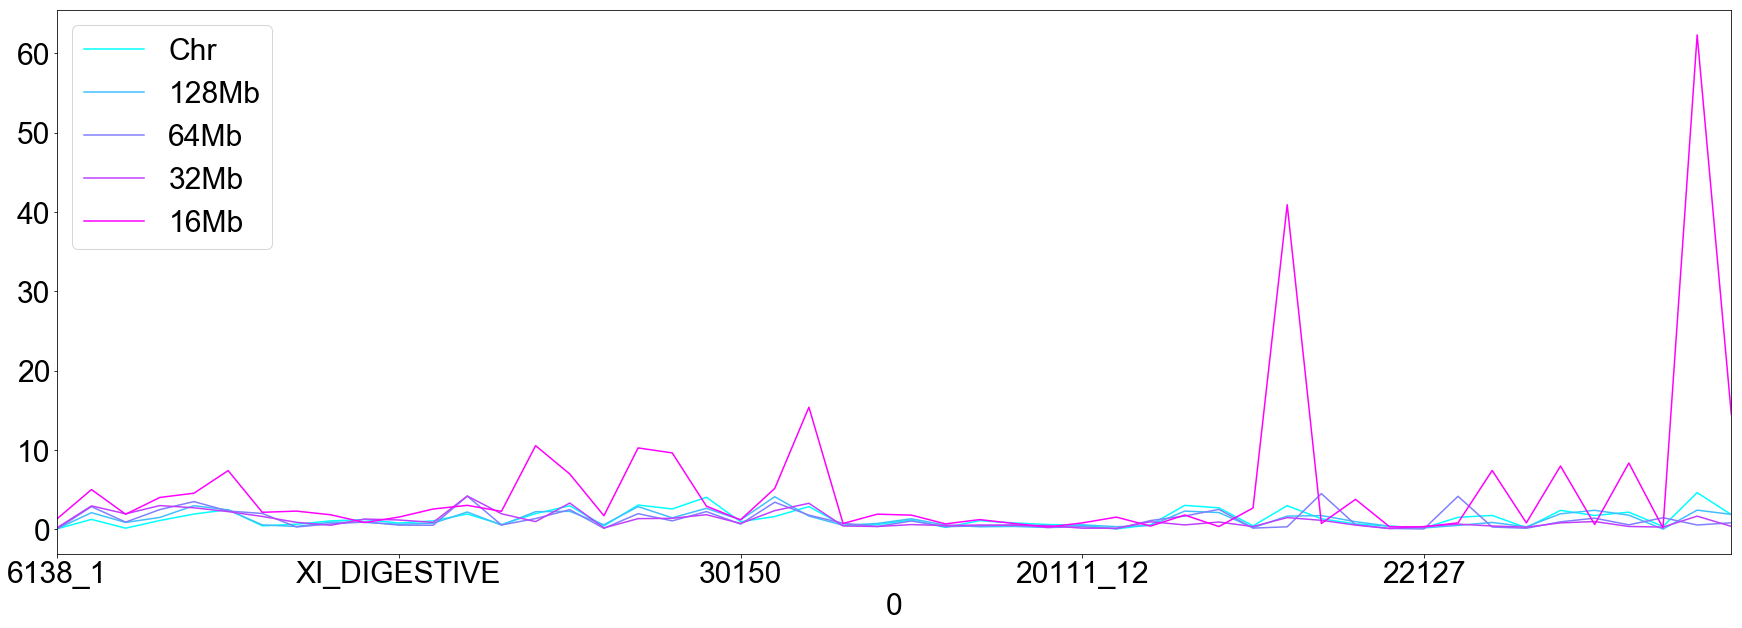

In [431]:
plt.rcParams["figure.figsize"] = (30,10)
anova_plot_data_normalized[index_select].T.plot(cmap=plt.cm.cool)

In [432]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [433]:
anova_plot_data_normalized

,6138_1,23115_irnt,2139_irnt,23104_irnt,23119_irnt,1180,23099_irnt,23112_irnt,23106_irnt,48_irnt,...,20426,N39,3005,680_4,5109_irnt,22147_irnt,20454,1717,4407,20543
Chr,0.077730,1.262154,0.152632,1.122422,1.933260,0.474636,1.643733,1.096069,1.321530,1.913133,...,0.517483,4.104262,4.492230,4.902564,4.919185,2.316489,0.671192,0.826812,2.992905,3.447992
128Mb,0.105640,2.104953,0.875355,1.509764,2.989561,0.260078,2.192712,1.322489,0.695589,2.095506,...,0.323040,2.146817,2.589327,2.719855,2.804571,1.678352,0.794381,0.131115,1.319916,1.788909
64Mb,0.082091,2.868289,0.916412,2.496869,3.504301,0.778643,2.539238,1.983640,3.077593,2.413276,...,0.081611,0.497033,0.883453,0.896174,0.951717,0.522228,0.355465,2.774144,0.307823,0.428099
32Mb,0.227632,2.963532,1.960877,3.002751,2.725754,0.856703,2.281075,2.531684,3.211021,2.621790,...,0.224111,0.872019,1.386640,1.247184,1.275592,1.451482,1.180903,0.108406,1.112866,0.580140
16Mb,1.361490,5.021501,1.911175,4.025293,4.563324,0.557764,4.654972,3.227450,2.444414,2.113673,...,5.289118,49.849152,24.034265,52.532065,36.631812,20.720632,4.564014,0.132350,45.173419,32.858906


In [441]:
pca_data=anova_plot_data_normalized.T
pca = PCA(n_components=3)
pca_result=pca.fit_transform(pca_data)
pca_result = pd.DataFrame(pca_result,index=pca_data.index)

In [442]:
#pca_result

In [443]:
pca.explained_variance_ratio_

array([0.94076052, 0.04291723, 0.0094284 ])

In [444]:
pca.components_

array([[ 0.08007402,  0.0338888 , -0.01390442,  0.01453602,  0.99600957],
       [ 0.37208366,  0.49679371,  0.64870629,  0.43815546, -0.04415533],
       [-0.66695972, -0.33408858,  0.21961186,  0.62597837,  0.05891745]])

In [445]:
pca.components_[0]*-0.5+pca.components_[1]*0

array([-0.04003701, -0.0169444 ,  0.00695221, -0.00726801, -0.49800479])

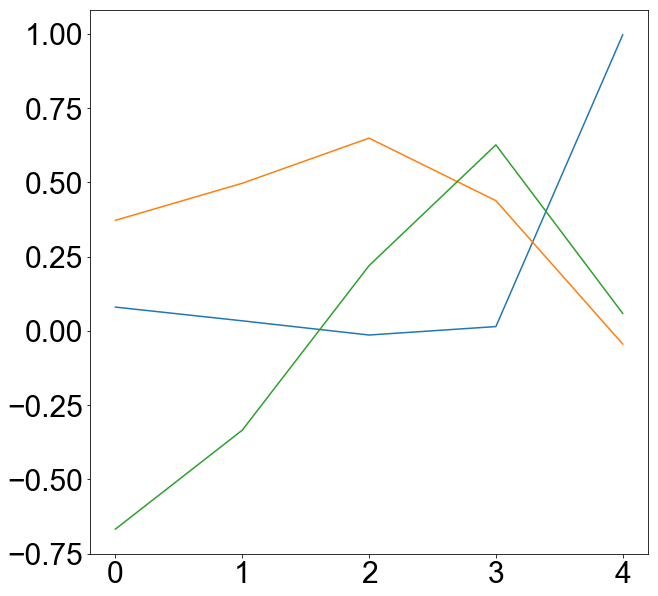

In [446]:
plt.plot(pd.DataFrame(pca.components_).T)

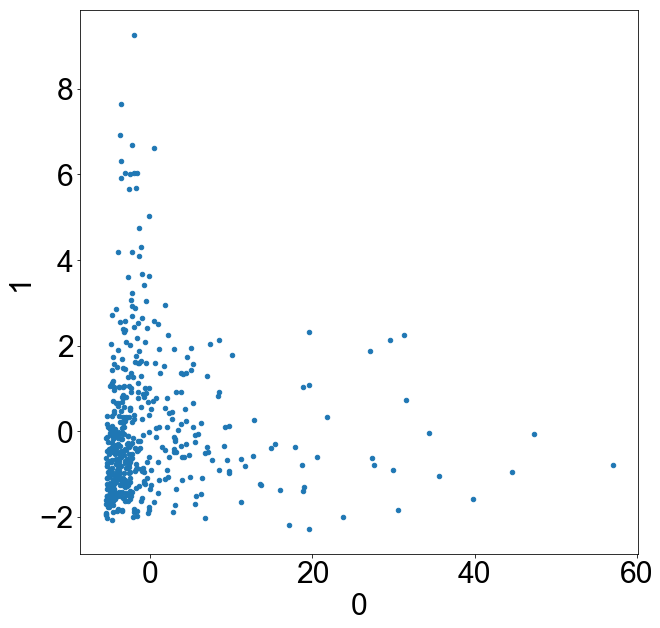

In [450]:
plt.rcParams["figure.figsize"] = (10,10)
pca_result.plot.scatter(x=0,y=1)

#plt.xlim(-5,5)
#plt.ylim(-3,3)

In [456]:
#anova_plot_data.T

In [451]:
tsne_data=pca_result

tsne = TSNE(learning_rate=100,perplexity=10)
#tsne = TSNE(learning_rate=200)
tsne_result = pd.DataFrame(tsne.fit_transform(tsne_data),index=tsne_data.index)

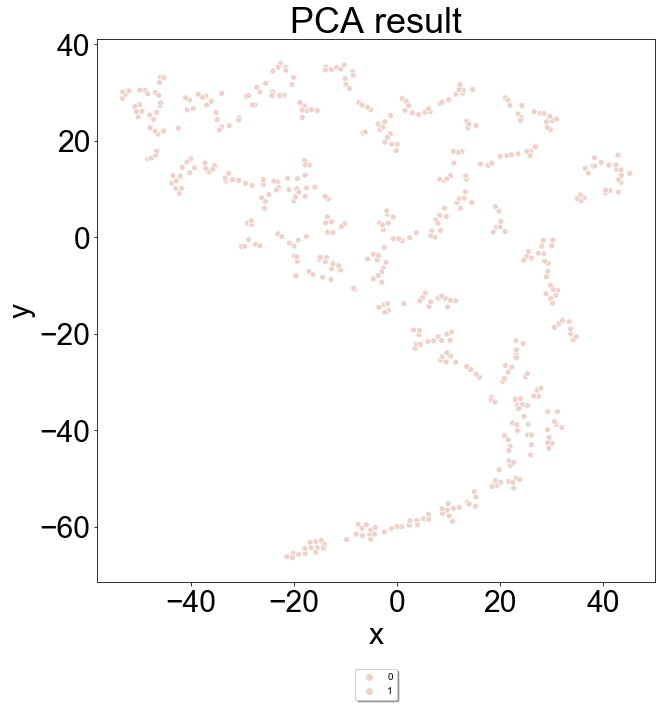

In [452]:
plot_data=tsne_result
x_data=plot_data[0]
y_data=plot_data[1]

#hue_data=[h2_total.loc[pheno_code]['uni.Total Liability scale h2'] for  pheno_code in pheno_code_list]
#hue_data=[corr_with_dummy_cm_dict['snp'].loc[pheno_code]['cm8'] for  pheno_code in toplot.index]
hue_data=1

plt.title("PCA result")
sns.scatterplot(x_data,y_data,hue=hue_data)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10,fancybox=True, shadow=True)


plt.show()

In [373]:
dbscan=DBSCAN(eps=3, min_samples=2)
dbscan_result=dbscan.fit(tsne_result)

In [374]:
plot_data=tsne_result.copy()
plot_data.columns=['x_data','y_data']
plot_data['label']=dbscan_result.labels_

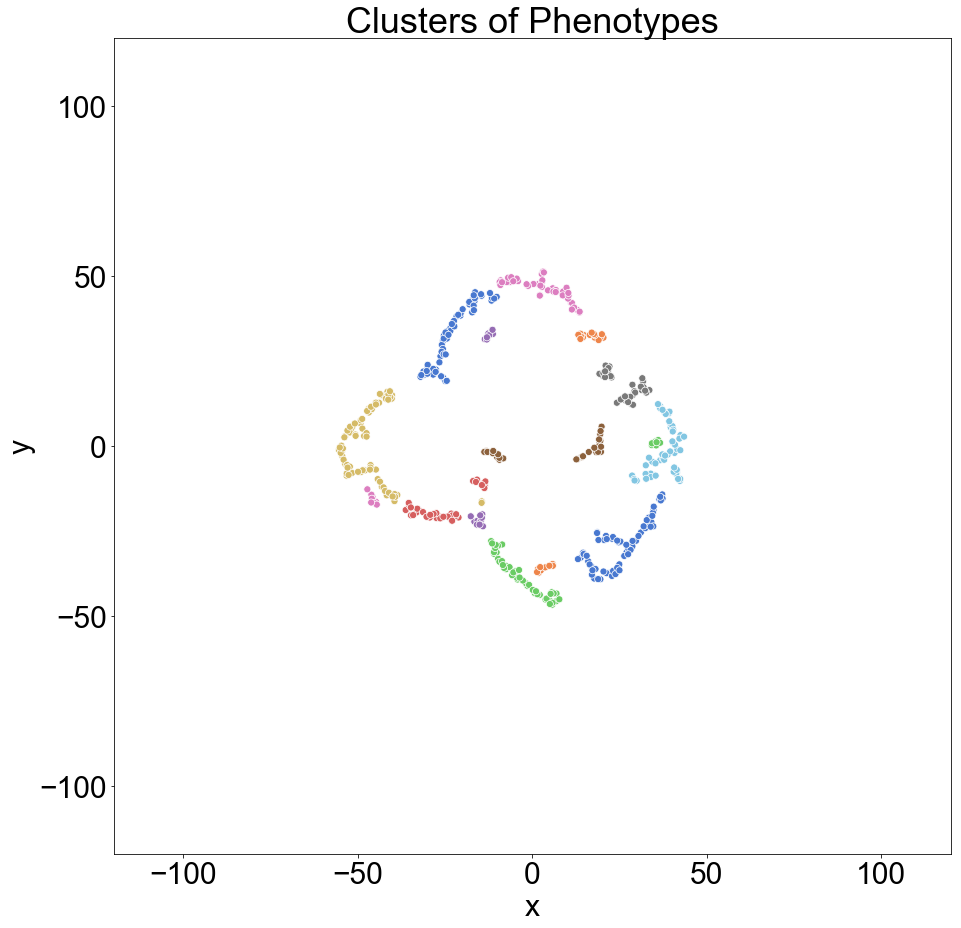

In [375]:
plt.rcParams['font.family']='Arial'

plt.rcParams["figure.figsize"] = (15,15)

x_data=plot_data['x_data']
y_data=plot_data['y_data']
hue_data=plot_data['label']

#group_list=plot_data['label']
#group_list=group_list.groupby(group_list).groups
#group_count=pd.Series(0,index=group_list.keys())

plt.title("Clusters of Phenotypes")
sns.scatterplot(x_data,y_data,hue=hue_data,legend=None,s=50,palette=sns.color_palette("muted",n_colors=len(np.unique(hue_data))))



"""
#r_sample=dup_sort(np.arange(0.04,0.071,0.005))
r_sample=np.arange(10,40,10)
theta_sample=2*np.pi*np.arange(0,1,1/30)
#theta_sample=2*np.pi*np.arange(0,1,0.05)
theta_sample=theta_sample[theta_sample%np.pi>np.pi/5]

text_plotted=pd.DataFrame([])

for label in plot_data['label'].unique():
    plot_data_filtered=plot_data[plot_data['label']==label]
    plot_data_filtered['description_short']=plot_data_filtered.index.map(code_to_description).map(lambda x: description_to_short(x,'abbr_pub'))
    #print(index_shorten[~index_shorten.isnull()])
    plot_data_filtered=plot_data_filtered[~plot_data_filtered['description_short'].isnull()].iloc[:2]
    if plot_data_filtered.shape[0]<2:
        continue
    s=plot_data_filtered['description_short'].values
    s='\n'.join(s)
    xy=np.array([plot_data_filtered['x_data'].mean(), plot_data_filtered['y_data'].mean()])
    np.random.shuffle(theta_sample)
    move_sample=[(r*np.cos(theta),r*np.sin(theta)) for theta in theta_sample for r in r_sample]
    #print(xy)
    
    for move in move_sample:
        xytext=xy+move
        if text_plotted.shape[0]==0 or (((text_plotted['x']-xytext[0])**2+0.4*(text_plotted['y']-xytext[1])**2)<1000).sum()==0:
            plt.annotate(s,xy=xy,xytext=xytext,arrowprops=dict(arrowstyle="- >",connectionstyle="arc3,rad=0.3"),bbox= dict(boxstyle="round,pad=0.3", fc=(1,1,1,1), ec="black", lw=0.5))
            text_plotted=text_plotted.append(pd.DataFrame([{'x':xytext[0],'y':xytext[1]}]))
            break

"""



plt.xlabel("x")
plt.ylabel("y")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10,fancybox=True, shadow=True,ncol=5)

plt.xlim(-120,120)
plt.ylim(-120,120)


plt.show()